<a href="https://colab.research.google.com/github/SaleemAmu/plane-classification/blob/main/train_classification_model_with_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [ ]:
# curl: download data and save to file
! curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
! tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  28.8M      0  0:01:31  0:01:31 --:--:-- 29.3M
mv: cannot move 'fgvc-aircraft-2013b' to 'dataset/fgvc-aircraft-2013b': Directory not empty


# Import Libraries

In [ ]:

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from PIL import Image



In [ ]:
# verify version keras
keras.__version__

'2.8.0'

# Constante


In [ ]:
#DATA_DIR = pathlib.Path('dataset/data')# pep8 : proposition d'amelioration de python
#DATA_DIR

#IMAGE_WIDTH = 128
#IMAGE_HEIGHT = IMAGE_WIDTH
#IMAGE_DEPTH = 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import yaml
#import yaml

yaml_file = open("/content/drive/MyDrive/model/learn.yaml", 'r')
yaml_content = yaml.load(yaml_file)

print("Key: Value")
for key, value in yaml_content.items():
   print(f"{key}: {value}")


Key: Value
IMAGE_WIDTH: 128
IMAGE_HEIGHT: IMAGE_WIDTH
IMAGE_DEPTH: 3
DATA_DIR_TRAIN_MANUFACTURER: /content/dataset/data/images_manufacturer_train.txt
DATA_DIR_TRAIN_FAMILY: /content/dataset/data/images_family_train.txt
DATA_DIR_TRAIN_VARIANT: /content/dataset/data/images_variant_train.txt
DATA_DIR_TEST_MANUFACTURER: /content/dataset/data/images_manufacturer_test.txt
DATA_DIR_TEST_FAMILY: /content/dataset/data/images_family_test.txt
DATA_DIR_TEST_VARIANT: /content/dataset/data/images_variant_test.txt
TARGET_NAME: manufacturer
TARGET_NAME2: family
TARGET_NAME3: variant


In [ ]:

DATA_DIR = yaml_content['DATA_DIR_TRAIN_FAMILY']
IMAGE_WIDTH = yaml_content['IMAGE_WIDTH']
IMAGE_HEIGHT = yaml_content['IMAGE_WIDTH']
IMAGE_DEPTH = yaml_content['IMAGE_DEPTH']
TARGET_NAME = yaml_content['TARGET_NAME']
TARGET_NAME2 = yaml_content['TARGET_NAME2']
TARGET_NAME3 = yaml_content['TARGET_NAME3']
DATA_DIR_TRAIN_MANUFACTURER = yaml_content['DATA_DIR_TRAIN_MANUFACTURER']
DATA_DIR_TRAIN_FAMILY = yaml_content['DATA_DIR_TRAIN_FAMILY']
DATA_DIR_TRAIN_VARIANT = yaml_content['DATA_DIR_TRAIN_VARIANT']
DATA_DIR_TEST_MANUFACTURER = yaml_content['DATA_DIR_TEST_MANUFACTURER']
DATA_DIR_TEST_FAMILY = yaml_content['DATA_DIR_TEST_FAMILY']
DATA_DIR_TEST_VARIANT = yaml_content['DATA_DIR_TEST_VARIANT']

# Function buil_image_database()

In [ ]:
# allow to build our image database
def build_image_database(path, target):
    """Build a pandas dataframe with target class and access path to images.
   
    Parameters
    - - - - - -
    path (Path): path patern to read csv file containing images information.
    target (str): name of the target column.
   
    Returns
    - - - - -
    A pandas dataframe, including target class and path to image.
    """
   
   
    _df = pd.read_csv(path, sep='\t',
            names=['all'],
            dtype={'all': str} # ids are not int but string
            )

    # la fonction split() découpe sur une chaîne de charatères
    _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

    # la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
    _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

    # la colonne path contient le chemin d'accès à l'image
    _df['path'] = _df['image_id'].apply(lambda x:  pathlib.Path('dataset/data/images') / (x + '.jpg'))

    return _df.drop(columns=['all'])

## Verify of the function build_image_database()

In [ ]:
# apply build_image_database()
build_image_database(DATA_DIR_TRAIN_FAMILY, TARGET_NAME2).head(2)

,image_id,family,path
0,1025794,Boeing 707,dataset/data/images/1025794.jpg
1,1340192,Boeing 707,dataset/data/images/1340192.jpg


In [ ]:
# apply build_image_database()
build_image_database(DATA_DIR_TRAIN_VARIANT, TARGET_NAME3).head(2)

,image_id,variant,path
0,1025794,707-320,dataset/data/images/1025794.jpg
1,1340192,707-320,dataset/data/images/1340192.jpg


In [ ]:
# apply build_image_database() in order to create the dataframe manufacturer_df
manufacturer_df = build_image_database(DATA_DIR_TRAIN_MANUFACTURER,TARGET_NAME)

In [ ]:
# see the dataframe manufacturer_df
manufacturer_df.head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


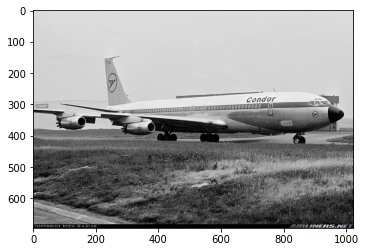

In [119]:
# show the image in manufacturer_df
plt.imshow(plt.imread(manufacturer_df.head(1)['path'].values[0]))

# Function Show_image()

In [ ]:
# the function :
# - take a df(argument)
#-take a row(row : argument)
#-take a column (target : argument)
# -it displays (the value of target ) and the associated image, for the line in argument


def show_image(df, row, target):
  """ Show an image from an image database , with the associated class

  Parameters
  -----------
  df(pd.DataFrame): images definition dataframe
  row(int):row index in df of image to be displayed
  target(str):name of target column

  Returns
  --------
  None
  """
  assert target in df.columns, "missing target column in dataframe"
  assert 'path' in df.columns , "Missing image path in dataframe"
  print(df.iloc[row, ][target])
  plt.imshow(plt.imread(df.iloc[row, ]['path']))
  return

# Function load_resize_image()

In [ ]:
def load_resize_image(path,height,width):
  """Load an image and resize it to the target size
    Parameters
    --------
    path(Path): access path to image file
    height(int): resize image to this height
    width(int):resize image to this width

    Returns
    ----------
    nb.array containing resize



  """
  
  return np.array(Image.open(path).resize((width, height)))

# Function build_classifiaction_model()

In [ ]:
def build_classification_model(df:pd.DataFrame, target:str, images:str):
  """Build a TF model using information from target and images columns in dataframe

  Parameters
  ---------------
  df(pd.Dataframe):dataframe with target and images columns
  target(str):column name for target variable
  images(str):column name for images


  Returns
  -----------
  TF model built & compiled
  """
  nb_classes=df[target].nunique()# compute number of classees for output layer
  size = df[images].iloc[0].shape# com
  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax'))# couche de sortie à nb_classes

  # #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Function build_x_and_y()

Build train & test set

In [ ]:
def build_x_and_y(df:pd.DataFrame,target:str,images:str,stratify=None):
  """Build x tensor and y tensor for model fitting 

  Parameters
  --------------
  df(pd.DataFrame):dataframe contanining images and target
  target(str):name of target column
  images(str): name of images column
  
  Returns
  ---------
  x(np.array):tensor of x values
  y(np.array):name of y values
  """
  x=np.array(df[images].to_list())
  y= tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  y_svm = np.array(df[target].astype("category").cat.codes)
 

  return x, y, y_svm


In [ ]:
# Load train & test dataset

train_df= build_image_database(DATA_DIR_TRAIN_FAMILY,TARGET_NAME2)
test_df= build_image_database(DATA_DIR_TEST_FAMILY,TARGET_NAME2)

train_df['resized_image']=train_df.apply(lambda r:load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)

test_df['resized_image']=test_df.apply(lambda r:load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)
#train_df
# Build tensors for training & testing

X_train,y_train,y_train_svm = build_x_and_y(train_df,TARGET_NAME2,'resized_image')
X_test,y_test,y_test_svm = build_x_and_y(test_df,TARGET_NAME2,'resized_image')

# BUILD TF classification model
model = build_classification_model(train_df,TARGET_NAME2,'resized_image')


In [ ]:
X_train.shape

(3334, 128, 128, 3)

train model

In [ ]:
# To be done once to retrieve the TPU information
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.115.213.18:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.115.213.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.115.213.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with tpu_strategy.scope():
  model= build_classification_model(train_df, TARGET_NAME2, 'resized_image')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 58, 58, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        36928     
                                                      

In [ ]:
%%time
epochs = 30
history = model.fit(X_train, y_train, batch_size=96, epochs=epochs, 
                    validation_data=(X_test, y_test),
                    #callbacks=[tensorboard_callback]
                    )

Epoch 1/30
35/35 [==============================] - 39s 809ms/step - loss: 14.2030 - accuracy: 0.0435 - val_loss: 4.1275 - val_accuracy: 0.0801
Epoch 2/30
35/35 [==============================] - 3s 82ms/step - loss: 4.1504 - accuracy: 0.0750 - val_loss: 4.0863 - val_accuracy: 0.0801
Epoch 3/30
35/35 [==============================] - 3s 82ms/step - loss: 4.1268 - accuracy: 0.0798 - val_loss: 4.0885 - val_accuracy: 0.0801
Epoch 4/30
35/35 [==============================] - 3s 83ms/step - loss: 4.1032 - accuracy: 0.0798 - val_loss: 4.0828 - val_accuracy: 0.0801
Epoch 5/30
35/35 [==============================] - 3s 83ms/step - loss: 4.0693 - accuracy: 0.0807 - val_loss: 4.0352 - val_accuracy: 0.0804
Epoch 6/30
35/35 [==============================] - 3s 81ms/step - loss: 4.0218 - accuracy: 0.0849 - val_loss: 3.9969 - val_accuracy: 0.0852
Epoch 7/30
35/35 [==============================] - 3s 85ms/step - loss: 3.9738 - accuracy: 0.0948 - val_loss: 3.9562 - val_accuracy: 0.0858
Epoch 8/30

In [ ]:
# verify the shape
X_test[10:11].shape

(1, 128, 128, 3)

In [ ]:
# the prediction of X_test[10:11]
np.argmax(model.predict(X_test[10:11]))

16

In [ ]:
# the probabilty of prediction of X_test[10:11]
model.predict(X_test[10:11])

array([[8.9585856e-03, 2.8550362e-03, 9.0849260e-03, 2.4818597e-02,
        7.5484835e-02, 8.7349107e-03, 3.2014765e-03, 3.4287301e-04,
        2.0509793e-03, 6.6520944e-03, 7.7891944e-04, 1.9206614e-03,
        1.9877192e-03, 5.4280629e-04, 2.4631994e-02, 7.3816635e-02,
        3.9567783e-01, 3.2034090e-03, 2.0455243e-02, 1.4302105e-02,
        6.9933746e-04, 1.7409646e-03, 2.8504359e-03, 3.4678376e-03,
        5.0007651e-04, 1.7681072e-04, 2.5804285e-03, 4.5855106e-03,
        8.7658269e-03, 1.0222701e-03, 3.0448148e-03, 5.7888605e-02,
        6.6001373e-03, 1.4658748e-04, 4.3671927e-05, 1.6805135e-04,
        1.5450582e-04, 1.0751619e-03, 6.1035575e-04, 3.8683347e-03,
        3.2533107e-03, 3.3841946e-03, 3.8285980e-03, 9.4804792e-03,
        5.9233448e-03, 9.5308488e-03, 4.6159662e-03, 1.4358450e-03,
        1.8483322e-03, 1.3043113e-03, 2.3354422e-03, 4.2515448e-03,
        2.3002928e-02, 1.0307523e-04, 9.9299839e-03, 8.8425144e-04,
        7.0734508e-03, 9.3859117e-03, 3.7588209e

In [ ]:
# see the categorisation of modality of manufacturer
test_df[TARGET_NAME2].astype('category').cat.codes

0       12
1       12
2       12
3       12
4       12
        ..
3328    69
3329    69
3330    69
3331    69
3332    69
Length: 3333, dtype: int8

In [ ]:
# see the modality of manaufacturer
test_df[TARGET_NAME2]

0       Boeing 707
1       Boeing 707
2       Boeing 707
3       Boeing 707
4       Boeing 707
           ...    
3328        Yak-42
3329        Yak-42
3330        Yak-42
3331        Yak-42
3332        Yak-42
Name: family, Length: 3333, dtype: object

Boeing 707


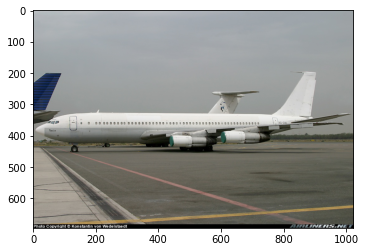

In [ ]:
# show image of the row equal to 10 for the target manufacturer
show_image(test_df, 10, TARGET_NAME2)

In [ ]:
# the prediction of X_test[10:20
#np.argmax(model.predict(X_test[10:20]), axis=1)

In [ ]:
# see the modality from the categorisation
train_df[TARGET_NAME2].astype('category').cat.categories

Index(['A300', 'A310', 'A320', 'A330', 'A340', 'A380', 'ATR-42', 'ATR-72',
       'An-12', 'BAE 146', 'BAE-125', 'Beechcraft 1900', 'Boeing 707',
       'Boeing 717', 'Boeing 727', 'Boeing 737', 'Boeing 747', 'Boeing 757',
       'Boeing 767', 'Boeing 777', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700',
       'Cessna 172', 'Cessna 208', 'Cessna Citation', 'Challenger 600',
       'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6',
       'DR-400', 'Dash 8', 'Dornier 328', 'EMB-120', 'Embraer E-Jet',
       'Embraer ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16',
       'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50',
       'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76',
       'King Air', 'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'PA-28',
       'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado', 'Tu-134',
       'Tu-154', 'Yak-42'],
      dtype='object')

# fucntion of the classify_image()

In [ ]:
def classify_images(images, model, classes_names=None):
  """Classify images through a TF model.
  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/ Keras model
  classes_names: dictionnary with classes names
  Returns
  -------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # np.argmax returns the index of the max value per row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

In [ ]:
# verification of the shape of the function classify_image()
classify_images(X_test, model).shape

(3333,)

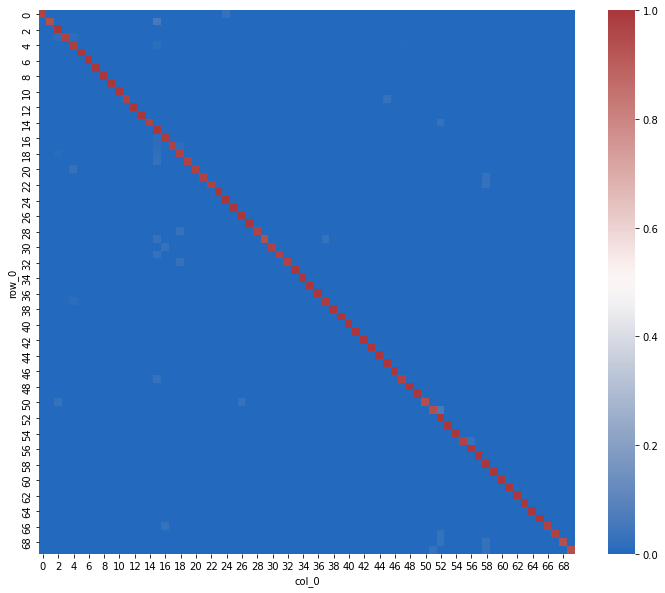

In [ ]:
# see the confusion matrix in the train
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_train, axis=1), 
                        classify_images(X_train, model), 
                        normalize='index'),
            cmap='vlag',
            ax=ax)

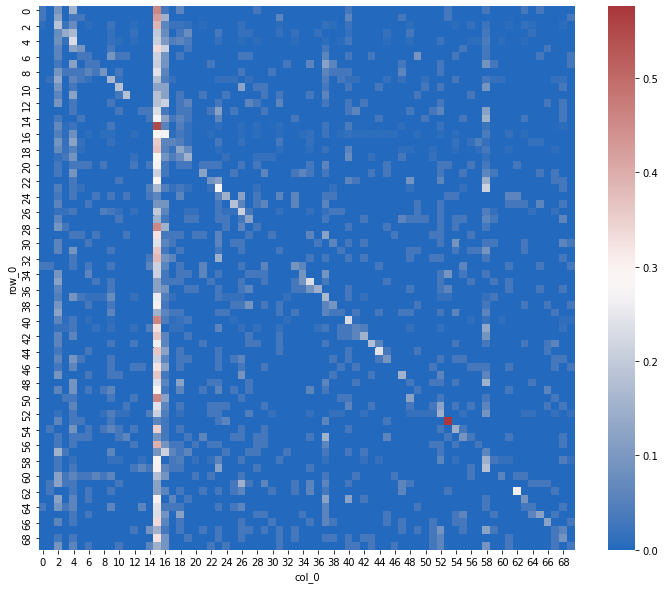

In [ ]:
# see the confusion matrix of the test
#we can see our model classifies genelrally the planes in 4
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_test, axis=1), 
                        classify_images(X_test, model), 
                        normalize='index'),
            cmap='vlag',
            ax=ax)

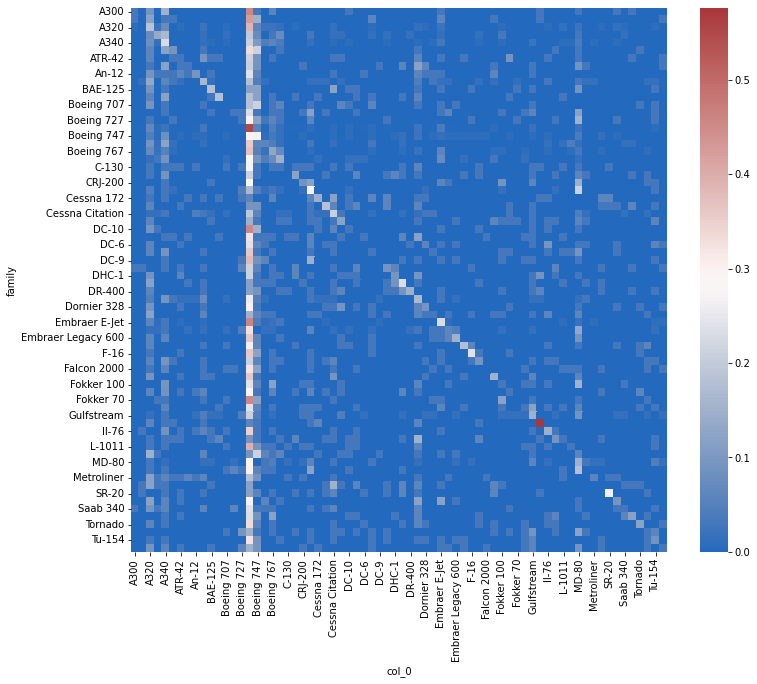

In [ ]:
# see the confusion matrix of the test
#we can see our model classifies genelrally the planes in Boeing
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(test_df[TARGET_NAME2], 
                        classify_images(X_test, model, test_df[TARGET_NAME2].astype('category').cat.categories), 
                        normalize='index'),
            cmap='vlag',
            ax=ax)

In [ ]:
# function save_model
#import datetime
#def save_model(model, basename):
  # """Save tf/Keras model

  # Model file is named model + timestamp.

  # Parameters
  # ----------
  # model (tf/Keras model): model to be saved
  # basename: location to save model file
  # """
  # model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
  # return

In [ ]:
# function save_model
import datetime
def save_model(model, basename):
  """Save tf/Keras model

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  model.save('{}.h5'.format(basename))
  return

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# apply the function save_model()
save_model(model, TARGET_NAME2)

In [ ]:
# relodded the model
#reloaded_model = load_model('/content/dataset/data_2022-04-05_19-38-28.h5')

In [ ]:
# prediction with the model reloaded
#np.argmax(reloaded_model.predict(X_test[10:20]), axis=1)

## SVM: DERNIERE VERSION

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
import seaborn as sns
import matplotlib as plt

In [ ]:
# Suppert vector machine

svc = SVC(kernel="linear", gamma = "auto")

In [ ]:
X_train.shape

(3334, 128, 128, 3)

array([[[[0.85882353, 0.85882353, 0.85882353],
         [0.85882353, 0.85882353, 0.85882353],
         [0.85882353, 0.85882353, 0.85882353],
         ...,
         [0.87058824, 0.87058824, 0.87058824],
         [0.86666667, 0.86666667, 0.86666667],
         [0.86666667, 0.86666667, 0.86666667]],

        [[0.85490196, 0.85490196, 0.85490196],
         [0.85490196, 0.85490196, 0.85490196],
         [0.85490196, 0.85490196, 0.85490196],
         ...,
         [0.86666667, 0.86666667, 0.86666667],
         [0.86666667, 0.86666667, 0.86666667],
         [0.86666667, 0.86666667, 0.86666667]],

        [[0.85490196, 0.85490196, 0.85490196],
         [0.85490196, 0.85490196, 0.85490196],
         [0.85490196, 0.85490196, 0.85490196],
         ...,
         [0.8627451 , 0.8627451 , 0.8627451 ],
         [0.8627451 , 0.8627451 , 0.8627451 ],
         [0.8627451 , 0.8627451 , 0.8627451 ]],

        ...,

        [[0.41176471, 0.41176471, 0.41176471],
         [0.41960784, 0.41960784, 0.41960784]

In [ ]:
# créer les flatten base de donnés (entre 0 et 1)
X_train_scaled_s = X_train / 255
X_test_scaled_s = X_test / 255

In [ ]:
lenofimage = len(X_train_scaled_s)
lenofimagetest = len(X_test_scaled_s)

In [ ]:
# redimensionnement
X_train_scaled_svc_s = X_train_scaled_s.reshape(lenofimage, -1) 
X_test_scaled_svc_s = X_test_scaled_s.reshape(lenofimagetest, -1) 

In [ ]:
y_train_svm.shape

(3334,)

In [ ]:
# Fiter le modèle
svc.fit(X_train_scaled_svc_s, y_train_svm)

SVC(gamma='auto', kernel='linear')

In [ ]:
y_predict_train=svc.predict(X_train_scaled_svc_s)

In [ ]:
# Faire une prédiction pour voir
y_predict = svc.predict(X_test_scaled_svc_s)

In [ ]:
svc.predict(X_test_scaled_svc_s)

array([15, 15, 58, ..., 67, 67, 56], dtype=int8)

In [ ]:
# creating a confusion matrix
cm_lin = confusion_matrix(y_test_svm, y_predict)


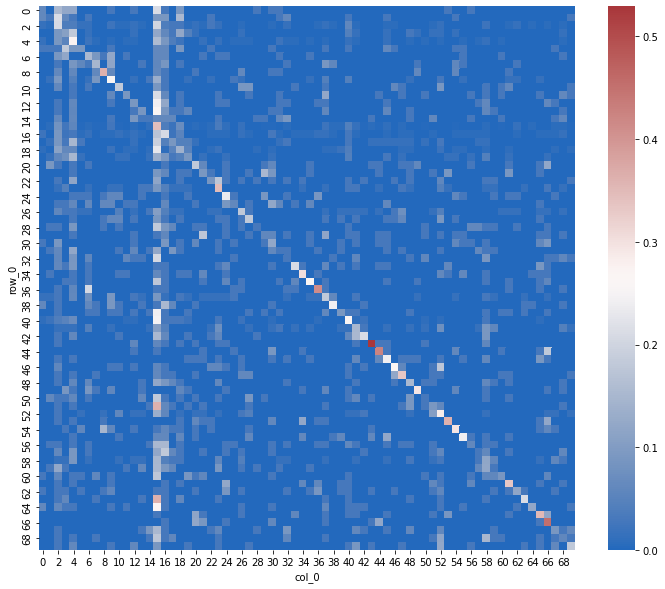

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.crosstab(y_test_svm,  y_predict,
                        normalize='index'),
            cmap='vlag'
            )


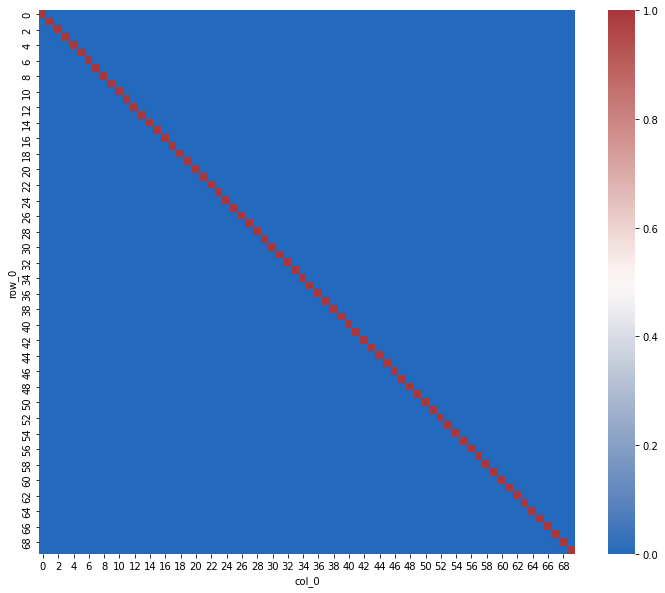

In [ ]:
# see the confusion matrix in the train
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(y_train_svm, 
                        y_predict_train, 
                        normalize='index'),
            cmap='vlag')
           

<bound method Series.unique of 0       Boeing 707
1       Boeing 707
2       Boeing 707
3       Boeing 707
4       Boeing 707
           ...    
3329        Yak-42
3330        Yak-42
3331        Yak-42
3332        Yak-42
3333        Yak-42
Name: family, Length: 3334, dtype: object>

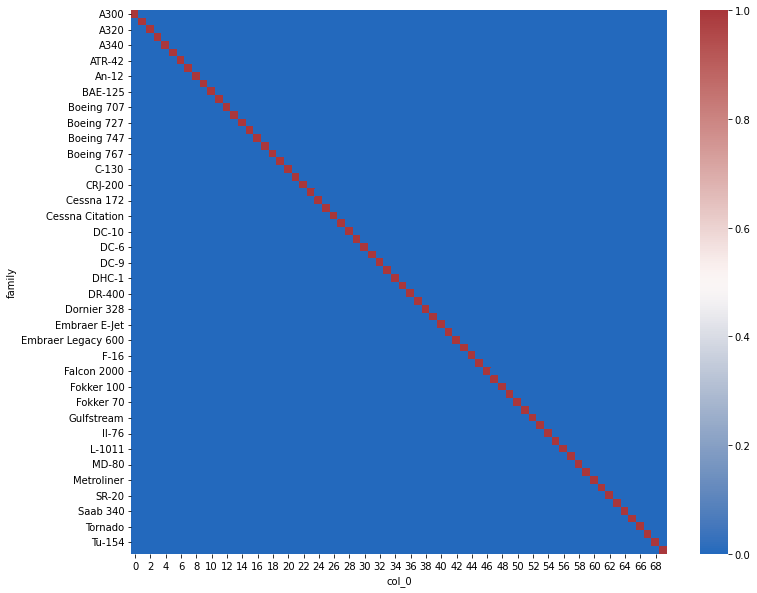

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(train_df[TARGET_NAME2], 
                        y_predict_train, 
                        normalize='index'),
            cmap='vlag')

In [ ]:
test_df[TARGET_NAME2]

0       Boeing 707
1       Boeing 707
2       Boeing 707
3       Boeing 707
4       Boeing 707
           ...    
3328        Yak-42
3329        Yak-42
3330        Yak-42
3331        Yak-42
3332        Yak-42
Name: family, Length: 3333, dtype: object

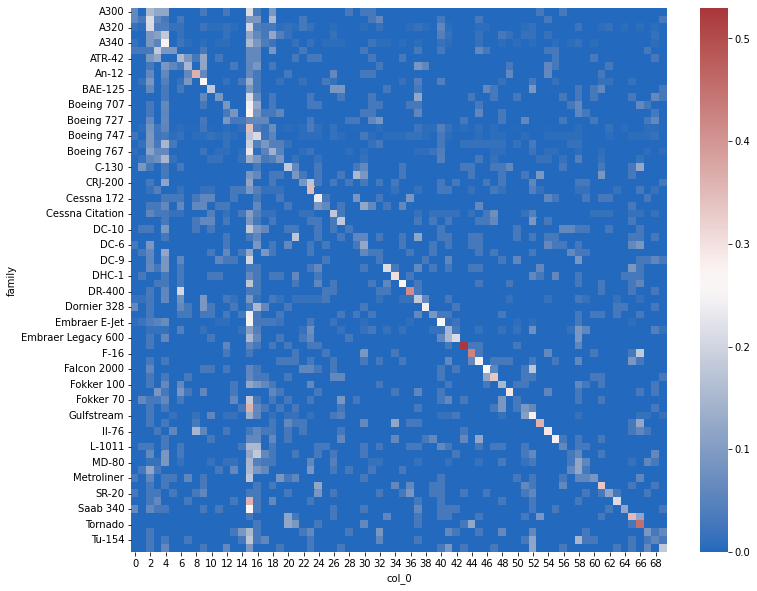

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(test_df[TARGET_NAME2],
                        y_predict,
                        normalize='index'),
            cmap='vlag',
            );

In [ ]:

print("The accuracy of the model is:", accuracy_score(y_test_svm,y_predict))

The accuracy of the model is: 0.285028502850285


In [ ]:
#file_dir = '/content/drive/MyDrive/image_classifier/base_dir.h5'
#base_model.save(file_dir)

In [ ]:
# importer le model avec pickle: pour le sauvegarder
pick = open("family_svc.sav", "wb")
pickle.dump(svc,pick)
pick.close

<function BufferedWriter.close>

In [ ]:
# allow to do for the manfacturer without restarting the constants part
TARGET_NAME2= TARGET_NAME
DATA_DIR_TRAIN_FAMILY=DATA_DIR_TRAIN_MANUFACTURER
DATA_DIR_TEST_FAMILY=DATA_DIR_TEST_MANUFACTURER

# conlusion 
the SVM model can predict approximately the same thing as the neural network model when we take the manufacturer and the family